# Amstel Gooi en Vecht

This script adds a new column "peilgebied_cat" and makes sure the peilgebieden allign with the HWS layer (Daniel):
- peilgebied_cat = 0 -> peilgebied
- peigelbied_cat = 1 -> RHWS (boezem)
- peilgebied_cat = 2 -> NHWS Notes:


In [3]:
import geopandas as gpd
import numpy as np

%load_ext autoreload
%autoreload 2

from general_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Amstel Gooi en Vecht

In [4]:
#define relative paths
waterschap = 'AmstelGooienVecht'
waterschap2 = 'AGV'

data_path = f"../projects/4750_20/Data_postprocessed/Waterschappen/{waterschap}/{waterschap2}.gpkg"

# Waterschaps boundaries
grens_path = "../projects/4750_30/Data_overig/Waterschapsgrenzen/Waterschapsgrenzen.geojson"

# Hoofdwatersysteem boundaries
hws_path = "../projects/4750_30/Data_overig/HWS/krw_basins_vlakken.gpkg"

# Buffer boundaries
buffer_path =  f"../projects/4750_30/Data_overig/HWS/hws_buffer_agv.gpkg"

# Buffer RWHS
rhws_path = f"../projects/4750_30/Data_overig/HWS/agv_rhws_buffer.gpkg"

# Output folder
output_folder = f"./Waterschappen/{waterschap}"

### Load Files

In [5]:
# Load HHNK files
AVG = read_gpkg_layers(gpkg_path = data_path, 
                    variables = ['stuw', 
                                 'gemaal', 
                                 'hydroobject',
                                 'duikersifonhevel',
                                 'peilgebied', 
                                 'streefpeil',
                                ])
AVG['peilgebied'] = AVG['peilgebied'].to_crs('EPSG:28992')

# Load waterschap boundaries
gdf_grens = gpd.read_file(grens_path)
gdf_grens = gdf_grens.to_crs('EPSG:28992')
gdf_grens = gdf_grens.set_index('waterschap')

# Load hws
gdf_hws = gpd.read_file(hws_path)

# Load buffer
gdf_buffer = gpd.read_file(buffer_path)
gdf_buffer = gdf_buffer.to_crs('EPSG:28992')
gdf_buffer = gdf_buffer.dissolve()

# Load rhws
gdf_rhws = gpd.read_file(rhws_path)
gdf_rhws = gdf_rhws.to_crs('EPSG:28992')
gdf_rhws = gdf_rhws.dissolve()

## Select waterschap boundaries and clip hws layer

In [6]:
# Select boundaries HH Amstel, Gooi en Vecht
gdf_grens = gdf_grens.loc[['HH Amstel, Gooi en Vecht']]

# Use waterschap boudnaries to clip HWS layer
gdf_hws = gpd.overlay(gdf_grens, gdf_hws, how='intersection')

# Use waterschap boudnaries to clip HWS layer
gdf_rhws = gpd.overlay(gdf_grens, gdf_rhws, how='intersection')

## RHWS is not included in AGV bron data, therefore create inverse difference layer to extract

/opt/tljh/user/envs/stable/lib/python3.8/site-packages/geopandas/tools/overlay.py:365: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[is_collection, geom_col] = dissolved[geom_col].values
/tmp/ipykernel_11898/807067864.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 51 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gdf_rhws = gpd.overlay(gdf_rhws, AVG['peilgebied'], how='difference')


<Axes: >

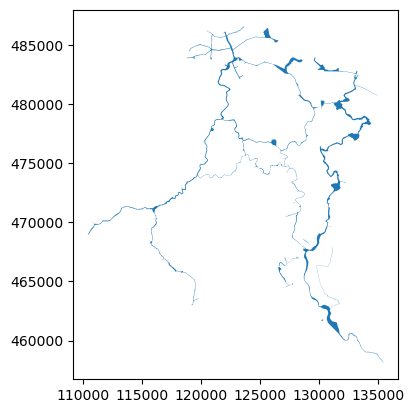

In [7]:
# Select inverse of peilgebied
gdf_rhws = gpd.overlay(gdf_rhws, AVG['peilgebied'], how='difference')
gdf_rhws = gpd.overlay(gdf_rhws, gdf_hws, how='difference')
gdf_rhws.plot()

## Peilgebied and HWS layer overlap:
1. Identify the overlapping areas
2. Clip
3. Calculate overlapping area percentage
4. Filter

In [84]:
# Step 1: Identify the Overlapping Areas and clip
overlaps = gpd.overlay(AVG['peilgebied'], gdf_hws, how='intersection', keep_geom_type=True)

# # Step 2: Subtract Overlapping Areas from the original polygons in each DataFrame
non_overlapping_peilgebied = gpd.overlay(AVG['peilgebied'], overlaps, how='difference', keep_geom_type=True)
overlaps = gpd.overlay(non_overlapping_peilgebied, gdf_hws, how='intersection', keep_geom_type=False)
 
# Step 3: Calculate Area Percentages
# Calculate the area of overlaps
overlaps['overlap_area'] = overlaps.area

# Step 4: Filter based on area Area Percentages
minimum_area = 500
print(f'Number of overlapping shapes without filter: {len(overlaps)}')
overlap_ids = overlaps.loc[overlaps['overlap_area'] > minimum_area]
overlap_ids = overlap_ids.globalid.to_list()
print(f'Number of overlapping shapes with filter: {len(overlap_ids)}')

Number of overlapping shapes without filter: 16
Number of overlapping shapes with filter: 0


In [85]:
# Add occurence to geodataframe
peilgebieden_cat = []

for index, row in AVG['peilgebied'].iterrows():
        peilgebieden_cat.append(0)
        
# Add new column and drop old HWS_BZM column
AVG['peilgebied']['peilgebied_cat'] = peilgebieden_cat
# HD['peilgebied'] = HD['peilgebied'].drop(columns=['streefpeil'])

## Add rhws to ['peilgebied','streefpeil']

In [86]:
# update peilgebied dict key
gdf_rhws['globalid'] = 'dummy_globalid_rhws_' + gdf_rhws.index.astype(str)
gdf_rhws['code'] = 'dummy_code_nhws_' + gdf_rhws.index.astype(str)
gdf_rhws['nen3610id'] = 'dummy_nen3610id_rhws_' + gdf_rhws.index.astype(str)
gdf_rhws['peilgebied_cat'] = 1

gdf_rhws = gdf_rhws[['globalid', 'code', 'nen3610id', 'peilgebied_cat', 'geometry']]

AVG['peilgebied'] = pd.concat([gdf_rhws, AVG['peilgebied']])

In [87]:
# Create boezem streefpeil layer
streefpeil_hws = pd.DataFrame()
streefpeil_hws['waterhoogte'] = [np.nan] * len(gdf_rhws)
streefpeil_hws['globalid'] = 'dummy_globalid_rhws_' + gdf_rhws.index.astype(str)
streefpeil_hws['geometry'] = [None]* len(gdf_rhws)

AVG['streefpeil'] = pd.concat([streefpeil_hws, AVG['streefpeil']])
AVG['streefpeil'] = gpd.GeoDataFrame(AVG['streefpeil'])

## Add nhws to ['peilgebied','streefpeil']

In [88]:
# update peilgebied dict key
gdf_hws['globalid'] = 'dummy_globalid_nhws_' + gdf_hws.index.astype(str)
gdf_hws['code'] = 'dummy_code_nhws_' + gdf_hws.index.astype(str)
gdf_hws['nen3610id'] = 'dummy_nen3610id_nhws_' + gdf_hws.index.astype(str)
gdf_hws['peilgebied_cat'] = 2

gdf_hws = gdf_hws[['globalid', 'code', 'nen3610id', 'peilgebied_cat', 'geometry']]

AVG['peilgebied'] = pd.concat([gdf_hws, AVG['peilgebied']])

In [89]:
# Create boezem streefpeil layer
streefpeil_hws = pd.DataFrame()
streefpeil_hws['waterhoogte'] = [np.nan] * len(gdf_hws)
streefpeil_hws['globalid'] = 'dummy_globalid_nhws_' + gdf_hws.index.astype(str)
streefpeil_hws['geometry'] = [None]* len(gdf_hws)

AVG['streefpeil'] = pd.concat([streefpeil_hws, AVG['streefpeil']])
AVG['streefpeil'] = gpd.GeoDataFrame(AVG['streefpeil'])

## Store output

In [93]:
for key in AVG.keys():   
    print(key)
    AVG[str(key)].to_file(f'{output_folder}/{waterschap2}.gpkg', layer = str(key), driver='GPKG')

stuw
gemaal
hydroobject
duikersifonhevel
peilgebied
streefpeil
